# The following code generates text files (2D data) that maps 3D/4D inputs and weight tensors to depthwise and pointwise convolutions for systolic arrays

In [1]:
# Import required libraries
import torchvision
import torch
from PIL import Image
import urllib
from torchvision import transforms
import numpy as np

In [ ]:
# Based on mobilenet architecture found here: https://medium.com/@godeep48/an-overview-on-mobilenet-an-efficient-mobile-vision-cnn-f301141db94d

# For point-wise convolution
# Max rows (input) needed: 1024 without folding
# Max columns (weight filters) needed: 1024 without folding
# Max number of weight loads needed: Just 1 weight load (assuming everything fits)

# **Depthwise Convolution** Mapping Generator for Systolic Array

In [ ]:
# Sizes we can run for depth-wise convolution (for 64 x 64 systolic array)

# weight: (2,2,2) , input: (14,14,2)
# weight: (2,2,3) , input: (28,28,3)
# weight: (2,2,4) , input: (56,56,4)
# weight: (3,3,4) , input: (56,56,4)
# weight: (3,3,32) , input: (112,112,32) # mobilenet layer 1 depthwise


In [2]:
# Make the weight and input matrices (see paper diagram)
# weight shape = (3,3,32) = (width, height, numchannels)
# input shape = (112,112,32) = (width,height,numchannels)

weight_filter = torch.randint(0, 255, (2,2,2))
input = torch.randint(0, 255, (28, 28, 2))
N = 256 # systolic array size
#print(weight_filter)
#print(input)

In [3]:
# Code that writes to a text file, the names of all text files that will be generated for inputs and weights
# This will depend on the shape of weight filter and inputs
# This is specifically for depthwise convolution

weight_names = [] # number of times to reload weights = # of channels
input_names = [] # number rows * number of times weights are reloaded

# Make text files for input
for channel_index in range(0, input.shape[2]):
  for row_index in range(0, weight_filter.shape[0] * weight_filter.shape[1]): # number of rows is number of weights loaded
    input_names.append("depthwise_input_row_" + str(row_index) + "_iteration_" + str(channel_index) + ".txt")

# Make text files for weight
for channel_index in range(0, weight_filter.shape[2]):
    weight_names.append("depthwise_weight_load_iteration_" + str(channel_index) + ".txt")

with open('depthwise_weight_file_names.txt', 'w') as f:
    for line in weight_names:
        f.write("%s\n" % line)

with open('depthwise_input_file_names.txt', 'w') as f:
    for line in input_names:
        f.write("%s\n" % line)

In [ ]:
# Practice cell
# # Example input tensor
# input_tensor = torch.tensor([[0, 1, 2, 3, 4],
#                              [5, 6, 7, 8, 9],
#                              [10, 11, 12, 13, 14],
#                              [15, 16, 17, 18, 19],
#                              [20, 21, 22, 23, 24]])
# input_tensor = torch.tensor([[0, 1, 2],
#                             [3, 4, 5],
#                             [6, 7, 8]])
# # Example weight tensor
# weight_tensor = torch.tensor([[11, 12, 13],
#                               [21, 22, 23],
#                               [31, 32, 33]])

In [4]:
# Solved Problem: Added in all the required zero-padding for weights

num_PEs_notzero_weight = weight_filter.shape[0] * weight_filter.shape[1]
num_filter_weight = 1
zeroes = torch.zeros(N-num_PEs_notzero_weight, dtype=torch.uint8) # how many PEs along a column we need to zero pad
print("num PEs used is ", num_PEs_notzero_weight, ", N=", str(N), ", padding with ", str(len(zeroes)), " zeroes")

for weight_channel_index in range(0, weight_filter.shape[2]): # runs based on number of channels
  current_weight_channel_data = weight_filter[:,:,weight_channel_index] # each data txt uses only a single column
  current_weight_channel_data = torch.flatten(current_weight_channel_data)
  print("before zeros added: ", current_weight_channel_data.shape)
  current_weight_channel_data = torch.cat((current_weight_channel_data, zeroes), dim=0)
  print("after zeros added: ", current_weight_channel_data.shape)
  current_weight_channel_data = torch.unsqueeze(current_weight_channel_data, 0)
  # Now add in all the extra zero rows
  zeroes_full = torch.zeros(N, dtype=torch.uint8)
  zeroes_full = torch.unsqueeze(zeroes_full, 0)
  for extra in range(0, N-1): # we only have 1 row, so make N-1 zero rows afterward
   current_weight_channel_data = torch.cat((current_weight_channel_data, zeroes_full), dim=0)
  print(current_weight_channel_data.shape)
  np.savetxt('depthwise_weight_load_iteration_' + str(weight_channel_index) + ".txt", current_weight_channel_data.numpy(), fmt='%d') # use channel index as load iteration
  print("saved text file for weight load iteration " + str(weight_channel_index) + "!")

num PEs used is  4 , N= 256 , padding with  252  zeroes
before zeros added:  torch.Size([4])
after zeros added:  torch.Size([256])
torch.Size([256, 256])
saved text file for weight load iteration 0!
before zeros added:  torch.Size([4])
after zeros added:  torch.Size([256])
torch.Size([256, 256])
saved text file for weight load iteration 1!


In [ ]:
# Based on https://github.com/jmjeon94/MobileNet-Pytorch/blob/master/MobileNetV1.py
# They are doing padding for the depth-wise convolution with padding=1 (and stride=1 or 2)
# However padding is not implemented for this code. Stride is assumed 1

In [5]:
# Solved Problem: Need to add in extra fluff zeroes after the largest row
# Solved Problem: Still need to add zero-padding for input
# Solved Problem: Need to calculate how many cycles to wait for

for channel_index in range(0, input.shape[2]): # find all the input rows for each channel (number of times we load weights = # channels)
  input_values = []
  sys_array_row_index = 0
  for wi in range(0, weight_filter.shape[0]):
    for wj in range(0, weight_filter.shape[1]):
      input_values = []
      zeroes_append = [0] * sys_array_row_index # add zeroes depending on the row you are on
      input_values = input_values + zeroes_append # append the zeroes
      print(zeroes_append, sys_array_row_index)
      for ii in range(wi, input.shape[0] - weight_filter.shape[0] + 1 + wi):
        for jj in range(wj, input.shape[1] - weight_filter.shape[1] + 1 + wj):
          input_values.append(input[ii, jj, channel_index])
      print(f"For weight element at ({wi}, {wj}):")
      print("Input values this weight touches:", input_values)
      input_values = torch.tensor(input_values)
      # Add a single zero at the end of the inputs
      single_zero_at_end = torch.zeros(1, dtype=torch.uint8)
      input_values = torch.cat((input_values, single_zero_at_end), dim=0) # zero pad inputs
      print("total input_values: ", input_values)
      print("shape after both zeroes at beginning and adding one at end is ", input_values.shape)
      np.savetxt('depthwise_input_row_' + str(sys_array_row_index) + "_iteration_" + str(channel_index) + ".txt", input_values[None].numpy(), fmt='%d')
      sys_array_row_index = sys_array_row_index + 1


[] 0
For weight element at (0, 0):
Input values this weight touches: [tensor(108), tensor(51), tensor(241), tensor(92), tensor(177), tensor(73), tensor(183), tensor(144), tensor(180), tensor(30), tensor(71), tensor(218), tensor(62), tensor(106), tensor(57), tensor(91), tensor(3), tensor(142), tensor(183), tensor(171), tensor(191), tensor(198), tensor(147), tensor(223), tensor(6), tensor(56), tensor(43), tensor(3), tensor(188), tensor(176), tensor(46), tensor(158), tensor(42), tensor(118), tensor(31), tensor(169), tensor(242), tensor(47), tensor(27), tensor(126), tensor(196), tensor(176), tensor(215), tensor(25), tensor(170), tensor(217), tensor(52), tensor(97), tensor(222), tensor(190), tensor(36), tensor(29), tensor(126), tensor(92), tensor(99), tensor(39), tensor(13), tensor(173), tensor(201), tensor(51), tensor(113), tensor(187), tensor(146), tensor(58), tensor(222), tensor(219), tensor(31), tensor(37), tensor(203), tensor(214), tensor(107), tensor(209), tensor(133), tensor(34), ten

In [6]:
# Calculate how many cycles to wait for in depthwise convolution, before the next weight loading iteration
# The answer is [length of largest input row + (N-#rows in array)] + fluff
fluff = 5 # define 5 cycles of fluff
len_input_rows = (weight_filter.shape[0] * weight_filter.shape[1])
column_propagation_length = N - len_input_rows
cycles_wait = len_input_rows + column_propagation_length + fluff
with open('depthwise_num_cycles_wait_time.txt', 'w') as f:
  f.write("%s" % str(cycles_wait))

In [7]:
# Download all the generated files
# NOTE: It is up to the user to change the naming convention of the zip file, depending on the parameters they set
!zip -r /content/depthwise_input28x28_256x256_with_full_zero_padding.zip /content/


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2023.12.01/ (stored 0%)
  adding: content/.config/logs/2023.12.01/14.24.01.844580.log (deflated 56%)
  adding: content/.config/logs/2023.12.01/14.24.01.047839.log (deflated 57%)
  adding: content/.config/logs/2023.12.01/14.21.01.186711.log (deflated 86%)
  adding: content/.config/logs/2023.12.01/14.23.50.651734.log (deflated 59%)
  adding: content/.config/logs/2023.12.01/14.20.50.902054.log 

# **Pointwise Convolution** Mapping Generator for Systolic Array

In [ ]:
# Mobilenet Paper: https://arxiv.org/pdf/1704.04861.pdf

In [ ]:
# Ones we can run (for 64x64 systolic array)

# weight: (1,1,4,8) , input: (28,28,4)
# weight: (1,1,8,16) , input: (28,28,8)
# weight: (1,1,16,32) , input: (56,56,16)
# weight: (1,1,32,32) , input: (56,56,32)
# weight: (1,1,32,64) , input: (112,112,32) -> mobilenet layer 1

# So we can plot 5 points

In [8]:
# This code works for standard convolution too! But the user needs to handle the multiple weight loading stages in the systolic array

# Make the weight and input matrices (see paper diagram)
# weight shape = (1,1,32,64) = (width, height, numchannels, numfilters)
# input shape = (112,112,32) = (width,height,numchannels)

weight_filter = torch.randint(0, 255, (1,1,256,256))
input = torch.randint(0, 255, (21,21,256)) # Check, does the input image need padding for that layer?
N = 256 # systolic array size
# print(weight_filter)
# print(input)

In [9]:
# Save a text file that tells us what the shapes of the inputs and weights are
print("weight size is: " + str(weight_filter.shape))
print("input size is: " + str(input.shape))
f = open('sizes_info.txt', 'w')
f.write("weight size is: " + str(weight_filter.shape) +"\n")
f.write("input size is: " + str(input.shape) + "\n")
f.write("weight follows (width, height, numchannels, numfilters)" + "\n")
f.write("input follows (width, height, numchannels)")
f.close()
print("done!")

weight size is: torch.Size([1, 1, 256, 256])
input size is: torch.Size([21, 21, 256])
done!


In [10]:
# Code that writes to a text file, the names of all text files that will be generated for inputs and weights
# This will depend on the shape of weight filter and inputs
# This is specifically for pointwise convolution

weight_names = ["pointwise_weight_load_iteration_0.txt"] # only one weight load for pointwise
input_names = []

for channel_index in range(0, input.shape[2]):
  input_names.append("pointwise_input_row_" + str(channel_index) + ".txt")

with open('weight_file_names.txt', 'w') as f:
    for line in weight_names:
        f.write("%s\n" % line)

# with open("input_file_names.txt", "w") as f:
#     f.write(", ".join(input_names)) # ", ".join(data)

with open('input_file_names.txt', 'w') as f:
   for line in input_names:
       f.write("%s " % line)

# Change the text file
# read lines from file
text = ""
with open('input_file_names.txt', 'r') as ifile:
    text = ifile.readline()
    #print(text)

# get all sepearte string split by space
data = text.split(" ")

# add quotes to each one
data = [f"\"{name}\"" for name in data]

# append them together with commas inbetween
updated_text = ", ".join(data)

# write to some file
with open("input_file_names.txt", 'w') as ofile:
    ofile.write(updated_text)

In [11]:
# Practice cell
# print(weight_filter.shape[2] * weight_filter.shape[3])
# print(weight_filter.shape[0])

# print(weight_filter[0,:,0,0])
# print(weight_filter[0,0,0,0])

# print(weight_filter[1,:,0,0])
# print(weight_filter[2,:,0,0])

# # Create a tensor of shape (4)
# tensor_4 = torch.tensor([1, 2, 3, 4])
# print(tensor_4.shape)

# # Use torch.unsqueeze to add a new dimension at the beginning
# tensor_1_4 = torch.unsqueeze(tensor_4, 0)
# print(tensor_1_4.shape)
# print(tensor_1_4)

In [12]:
# Solved problem: Extra rows are added that are zero padded (for weights)

num_channels_weight = weight_filter.shape[2]
num_filter_weight = weight_filter.shape[3]
zeroes = torch.zeros(N-num_channels_weight, dtype=torch.uint8) # how many PEs along a column we need to zero pad
print("num channels is ", num_channels_weight, ", N=", str(N), ", padding with ", str(len(zeroes)), " zeroes")

weight_load_iteration = 0
for weight_row_index in range(0, weight_filter.shape[0]):
  for weight_column_index in range(0, weight_filter.shape[1]): # number of times we will load weights = row_index * column_index.
  # This is the number of pipes for each filter
    weight_matrix = None
    for filter_index in range(0, weight_filter.shape[3]): # number of weight filters
      # create a pipe for each weight_filter, the pipe has dimension (1,1,channels) for pointwise convolution
      if weight_matrix is None:
        weight_matrix = weight_filter[weight_row_index, weight_column_index, :, filter_index] # get one value from each channel
        print("weight_matrix (before zero pad) shape is: ", weight_matrix.shape)
        weight_matrix = torch.cat((weight_matrix, zeroes), dim=0)
        print("weight matrix (after zero pad) shape is: ", weight_matrix.shape, ", where N is", str(N))
        weight_matrix = torch.unsqueeze(weight_matrix, 0) # Make it from dimension (channel) to (1,channel) so we can concatenate later
        print(weight_matrix.shape)
      else:
        new_pipe = weight_filter[weight_row_index, weight_column_index, :, filter_index] # get one value from each channel
        print("new_pipe (before zero pad) shape is: ", new_pipe.shape)
        new_pipe = torch.cat((new_pipe, zeroes), dim=0)
        print("new_pipe (after zero pad) shape is: ", new_pipe.shape, ", where N is", str(N))
        new_pipe = torch.unsqueeze(new_pipe, 0)
        weight_matrix = torch.cat((weight_matrix, new_pipe), dim=0)
        print("weight_matrix shape is: ", weight_matrix.shape)
    # Add in the extra zero rows (if there are any)
    zeroes_full = torch.zeros(N, dtype=torch.uint8)
    zeroes_full = torch.unsqueeze(zeroes_full, 0)
    for extra in range(0, N-num_filter_weight):
      weight_matrix = torch.cat((weight_matrix, zeroes_full), dim=0)
    print(weight_matrix.shape)
    np.savetxt('pointwise_weight_load_iteration_' + str(weight_load_iteration) + ".txt", weight_matrix.numpy(), fmt='%d')
    print("saved text file for weight load iteration " + str(weight_load_iteration) + "!")
    weight_load_iteration = weight_load_iteration + 1

num channels is  256 , N= 256 , padding with  0  zeroes
weight_matrix (before zero pad) shape is:  torch.Size([256])
weight matrix (after zero pad) shape is:  torch.Size([256]) , where N is 256
torch.Size([1, 256])
new_pipe (before zero pad) shape is:  torch.Size([256])
new_pipe (after zero pad) shape is:  torch.Size([256]) , where N is 256
weight_matrix shape is:  torch.Size([2, 256])
new_pipe (before zero pad) shape is:  torch.Size([256])
new_pipe (after zero pad) shape is:  torch.Size([256]) , where N is 256
weight_matrix shape is:  torch.Size([3, 256])
new_pipe (before zero pad) shape is:  torch.Size([256])
new_pipe (after zero pad) shape is:  torch.Size([256]) , where N is 256
weight_matrix shape is:  torch.Size([4, 256])
new_pipe (before zero pad) shape is:  torch.Size([256])
new_pipe (after zero pad) shape is:  torch.Size([256]) , where N is 256
weight_matrix shape is:  torch.Size([5, 256])
new_pipe (before zero pad) shape is:  torch.Size([256])
new_pipe (after zero pad) shape i

# Input text file generator (for point-wise convolution)

In [ ]:
# Luckily, in point-wise convolution since the weight filter is a single pipe, we don't have to worry about padding
# We can assume the input size will be 3-dimensional throughout all layers (see https://medium.com/@godeep48/an-overview-on-mobilenet-an-efficient-mobile-vision-cnn-f301141db94d)

In [ ]:
# Practice cell
# t = torch.tensor([[1, 2, 3, 4],[5, 6, 7, 8]])
# print(t.shape)
# t = torch.flatten(t)
# print(t.shape)
# print(t)

torch.Size([2, 4])
torch.Size([8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])


In [13]:
# each row into the systolic array gets a single channel's entire input data (unrolled)
# Solved Problem: ADD THE ZEROS FIRST IN THE SEQUENTIAL INPUT ROWS (SEE LECTURE NOTES DIAGRAM)
# Solved Problem: Need to zero-pad the inputs

for channel_index in range(0, input.shape[2]):
  each_channel_data = input[:,:,channel_index]
  each_channel_data = torch.flatten(each_channel_data)
  zeroes_append = torch.zeros(channel_index, dtype=torch.uint8)
  print(zeroes_append)
  each_channel_data = torch.cat((zeroes_append, each_channel_data), dim=0)
  single_zero_at_end = torch.zeros(1, dtype=torch.uint8)
  each_channel_data = torch.cat((each_channel_data, single_zero_at_end), dim=0) # zero-pad inputs
  print("shape after both zeroes at beginning and adding one at end is ", each_channel_data.shape)
  #print(each_channel_data)
  check_shape = each_channel_data.numpy()
  print(check_shape.shape)
  np.savetxt('pointwise_input_row_' + str(channel_index) + ".txt", each_channel_data[None].numpy(), fmt='%d')
  print("saved text file for systolic array input row " + str(channel_index) + "!")

tensor([], dtype=torch.uint8)
shape after both zeroes at beginning and adding one at end is  torch.Size([442])
(442,)
saved text file for systolic array input row 0!
tensor([0], dtype=torch.uint8)
shape after both zeroes at beginning and adding one at end is  torch.Size([443])
(443,)
saved text file for systolic array input row 1!
tensor([0, 0], dtype=torch.uint8)
shape after both zeroes at beginning and adding one at end is  torch.Size([444])
(444,)
saved text file for systolic array input row 2!
tensor([0, 0, 0], dtype=torch.uint8)
shape after both zeroes at beginning and adding one at end is  torch.Size([445])
(445,)
saved text file for systolic array input row 3!
tensor([0, 0, 0, 0], dtype=torch.uint8)
shape after both zeroes at beginning and adding one at end is  torch.Size([446])
(446,)
saved text file for systolic array input row 4!
tensor([0, 0, 0, 0, 0], dtype=torch.uint8)
shape after both zeroes at beginning and adding one at end is  torch.Size([447])
(447,)
saved text file f

In [14]:
### CHANGE THIS BASED ON N!
# It is up to the user to change the parameters of the naming convention for their downloaded zip file
!zip -r /content/pointwise_input21x21_array256x256.zip /content/

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2023.12.01/ (stored 0%)
  adding: content/.config/logs/2023.12.01/14.24.01.844580.log (deflated 56%)
  adding: content/.config/logs/2023.12.01/14.24.01.047839.log (deflated 57%)
  adding: content/.config/logs/2023.12.01/14.21.01.186711.log (deflated 86%)
  adding: content/.config/logs/2023.12.01/14.23.50.651734.log (deflated 59%)
  adding: content/.config/logs/2023.12.01/14.20.50.902054.log 

# Plot the data to generate results/figures

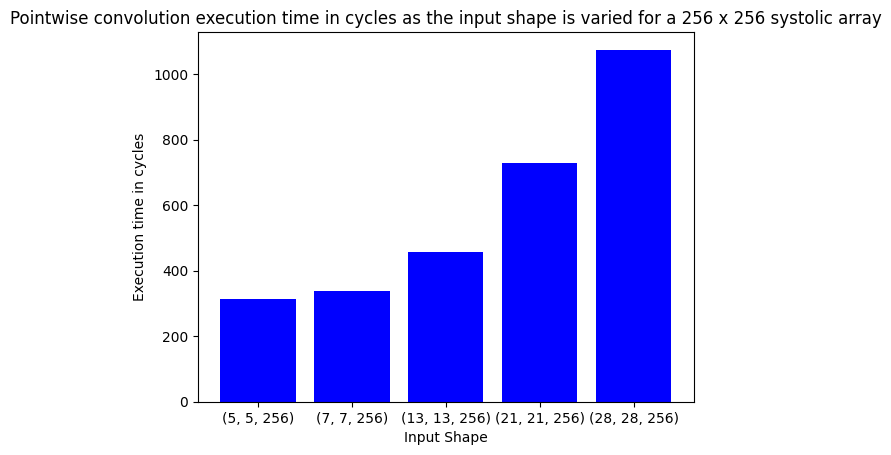

In [15]:
# Graphing the Data
# For Pointwise Convolution Data we gathered
import matplotlib.pyplot as plt

data = {
    (5, 5, 256): 313,
    (7, 7, 256): 337,
    (13, 13, 256): 457,
    (21, 21, 256): 729,
    (28, 28, 256): 1074,
}

# Extracting data for plotting
x_values = ["({}, {}, {})".format(*xyz) for xyz in data.keys()]
y_values = list(data.values())

# Plotting the bar graph
plt.bar(x_values, y_values, color='blue')

# Adding labels and title
plt.xlabel('Input Shape')
plt.ylabel('Execution time in cycles')
plt.title('Pointwise convolution execution time in cycles as the input shape is varied for a 256 x 256 systolic array')

# Display the plot
plt.show()


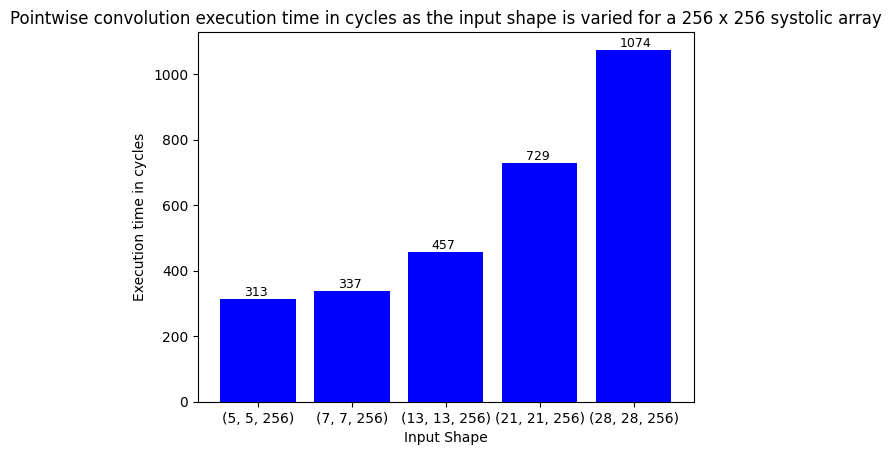

In [ ]:
import matplotlib.pyplot as plt

data = {
    (5, 5, 256): 313,
    (7, 7, 256): 337,
    (13, 13, 256): 457,
    (21, 21, 256): 729,
    (28, 28, 256): 1074,
}

# Extracting data for plotting
x_values = ["({}, {}, {})".format(*xyz) for xyz in data.keys()]
y_values = list(data.values())

# Plotting the bar graph
bars = plt.bar(x_values, y_values, color='blue')

# Adding labels and title
plt.xlabel('Input Shape')
plt.ylabel('Execution time in cycles')
plt.title('Pointwise convolution execution time in cycles as the input shape is varied for a 256 x 256 systolic array')

# Adding text labels inside each bar
for bar, label in zip(bars, y_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 10, str(label), fontsize=9)

# Display the plot
plt.show()


In [ ]:
# Depthwise Estimated Results calculation
N = 28
K = 2
num_channels = 2

# Calculate IR (Cycles based on longest Input row)
IR = 255 + (N - K + 1) * (N - K + 1)

# Calculate WT (Time for all weight loads)
WT = num_channels * 256

# Calculate Total time
total_time = WT + IR * num_channels

print("IR:", IR)
print("WT:", WT)
print("Total time:", total_time)


IR: 984
WT: 512
Total time: 2480


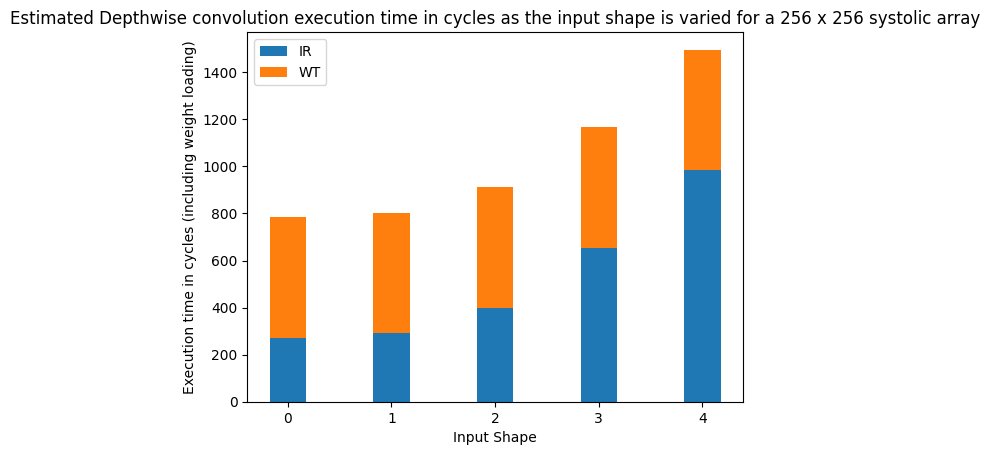

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = {
    (5, 5, 2): {'IR': 271, 'WT': 512, 'total': 1054},
    (7, 7, 2): {'IR': 291, 'WT': 512, 'total': 1094},
    (13, 13, 2): {'IR': 399, 'WT': 512, 'total': 1310},
    (21, 21, 2): {'IR': 655, 'WT': 512, 'total': 1822},
    (28, 28, 2): {'IR': 984, 'WT': 512, 'total': 2480},
}

# Extracting data for plotting
x_values = ["({}, {}, {})".format(*xyz) for xyz in data.keys()]
ir_values = [entry['IR'] for entry in data.values()]
wt_values = [entry['WT'] for entry in data.values()]
total_values = [entry['total'] for entry in data.values()]

# Plotting the stacked bar graph
fig, ax = plt.subplots()

bar_width = 0.35
bar_positions = np.arange(len(x_values))

bar1 = ax.bar(bar_positions, ir_values, bar_width, label='IR')
bar2 = ax.bar(bar_positions, wt_values, bar_width, label='WT', bottom=ir_values)

# Adding labels and title
plt.xlabel('Input Shape')
plt.ylabel('Execution time in cycles (including weight loading)')
plt.title('Estimated Depthwise convolution execution time in cycles as the input shape is varied for a 256 x 256 systolic array')

# Adding legend
ax.legend()

# Display the plot
plt.show()


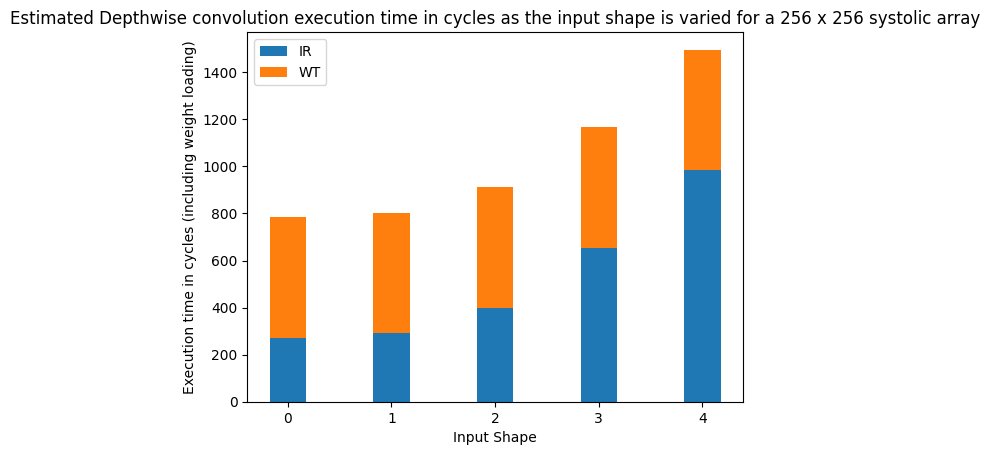

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = {
    (5, 5, 2): {'IR': 271, 'WT': 512, 'total': 1054},
    (7, 7, 2): {'IR': 291, 'WT': 512, 'total': 1094},
    (13, 13, 2): {'IR': 399, 'WT': 512, 'total': 1310},
    (21, 21, 2): {'IR': 655, 'WT': 512, 'total': 1822},
    (28, 28, 2): {'IR': 984, 'WT': 512, 'total': 2480},
}

# Extracting data for plotting
x_values = ["({}, {}, {})".format(*xyz) for xyz in data.keys()]
ir_values = [entry['IR'] for entry in data.values()]
wt_values = [entry['WT'] for entry in data.values()]
total_values = [entry['total'] for entry in data.values()]

# Plotting the stacked bar graph
fig, ax = plt.subplots()

bar_width = 0.35
bar_positions = np.arange(len(x_values))

bar1 = ax.bar(bar_positions, ir_values, bar_width, label='IR')
bar2 = ax.bar(bar_positions, wt_values, bar_width, label='WT', bottom=ir_values)

# Adding labels and title
plt.xlabel('Input Shape')
plt.ylabel('Execution time in cycles (including weight loading)')
plt.title('Estimated Depthwise convolution execution time in cycles as the input shape is varied for a 256 x 256 systolic array')

# Adding legend
ax.legend()

# Display the plot
plt.show()


['(5, 5, 2)', '(7, 7, 2)', '(13, 13, 2)', '(21, 21, 2)', '(28, 28, 2)']


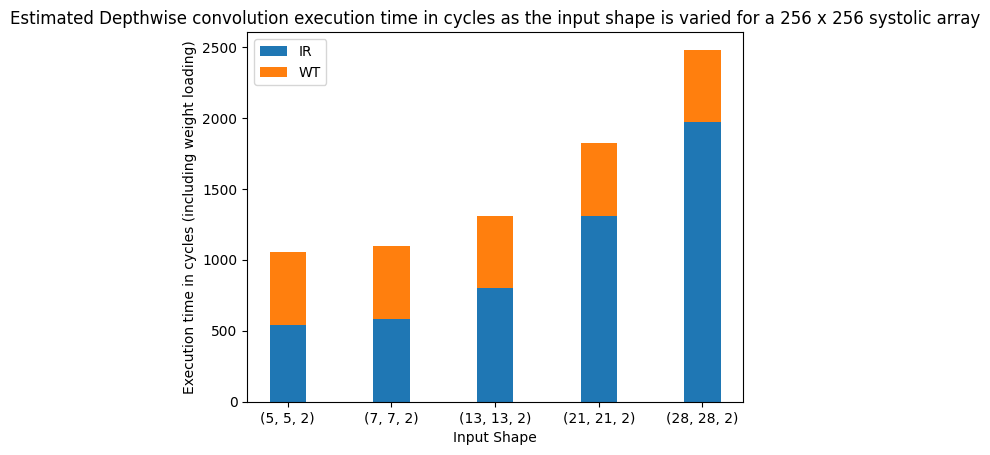

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = {
    (5, 5, 2): {'IR': 271*2, 'WT': 512, 'total': 1054},
    (7, 7, 2): {'IR': 291*2, 'WT': 512, 'total': 1094},
    (13, 13, 2): {'IR': 399*2, 'WT': 512, 'total': 1310},
    (21, 21, 2): {'IR': 655*2, 'WT': 512, 'total': 1822},
    (28, 28, 2): {'IR': 984*2, 'WT': 512, 'total': 2480},
}

# Extracting data for plotting
#x_values = ["({}, {}, {})".format(*list(data.keys())[0])] * len(data)
x_values = ["({}, {}, {})".format(*xyz) for xyz in data.keys()]

print(x_values)
ir_values = [entry['IR'] for entry in data.values()]
wt_values = [entry['WT'] for entry in data.values()]
total_values = [entry['total'] for entry in data.values()]

# Plotting the stacked bar graph
fig, ax = plt.subplots()

bar_width = 0.35
bar_positions = np.arange(len(x_values))

bar1 = ax.bar(bar_positions, ir_values, bar_width, label='IR')
bar2 = ax.bar(bar_positions, wt_values, bar_width, label='WT', bottom=ir_values)

# Adding labels and title
plt.xlabel('Input Shape')
plt.ylabel('Execution time in cycles (including weight loading)')
plt.title('Estimated Depthwise convolution execution time in cycles as the input shape is varied for a 256 x 256 systolic array')

# Adding legend
ax.legend()

# Setting x-axis ticks
ax.set_xticks(bar_positions)
ax.set_xticklabels(x_values)

# Display the plot
plt.show()


# Generate figure for Depthwise Convolution Model-sim (real simulation) results, as you vary the input shape

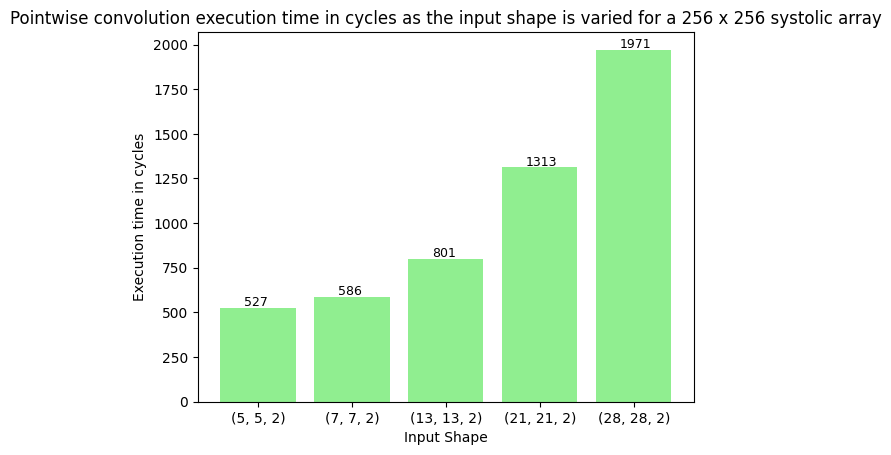

In [ ]:
import matplotlib.pyplot as plt

data = {
    (5, 5, 2): 527,
    (7, 7, 2): 586,
    (13, 13, 2): 801,
    (21, 21, 2): 1313,
    (28, 28, 2): 1971,
}

# Extracting data for plotting
x_values = ["({}, {}, {})".format(*xyz) for xyz in data.keys()]
y_values = list(data.values())

# Plotting the bar graph
bars = plt.bar(x_values, y_values, color='lightgreen')

# Adding labels and title
plt.xlabel('Input Shape')
plt.ylabel('Execution time in cycles')
plt.title('Depthwise convolution execution time in cycles as the input shape is varied for a 256 x 256 systolic array')

# Adding text labels inside each bar
for bar, label in zip(bars, y_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 10, str(label), fontsize=9)

# Display the plot
plt.show()